In [184]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pandas as pd

In [185]:
T = 0.03
s = ctl.TransferFunction.s

C = 1/(1.59154943091895*s + 1.0)
C

TransferFunction(array([1]), array([1.59154943, 1.        ]))

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [186]:
C_z = ctl.c2d(C, T, method='tustin')
C_z

TransferFunction(array([0.00933678, 0.00933678]), array([ 1.        , -0.98132644]), 0.03)

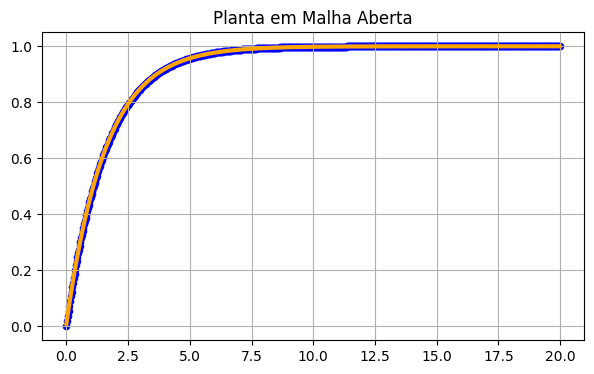

In [187]:
time = np.arange(0, 20, T)
time, continuous = ctl.step_response(C, T=time)
time, digital    = ctl.step_response(C_z, T=time)

plt.figure(figsize=(7, 4))
plt.scatter(time, continuous, color='blue', s=20, label='tempo discreto')
plt.plot(time, digital, color='orange', linewidth=3, label='tempo contínuo')
plt.title('Planta em Malha Aberta')
plt.grid()

# DIGITALIZANDO O SISTEMA
- Preparando as funções que permitem digitalizar a função de transferência em transformada $Z$
    - **getOutputString**: Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada
    - **resetSystem**: reinicia as variáveis globais do sistema
    - **compute**: aplica a função digitalizada a partir dos estados anteriores

In [188]:
def getDigitalFraction(G_z):
    num, den = ctl.tfdata(G_z)
    num = np.squeeze(num)
    den = np.squeeze(den)

    num = num/den[0]
    den = den/den[0]

    if type(num) == np.float64:
        num = np.array([num])

    return list(num), list(den)


num, den = getDigitalFraction(C_z)
num, den

([0.00933678087416201, 0.00933678087416212], [1.0, -0.9813264382516759])

In [189]:
def getModelString(G_z):
    num, den = getDigitalFraction(G_z)
    out = ''
    
    for i in range(0, len(num)): 
        out += f'Xn[{i}]*({num[i]:.6f}) + '

    for i in range(1, len(den)): 
        out += f'Yn[{i}]*({-1*den[i]:.6f}) + '
    
    out = out.replace('X_n0', 'X_n')[:-3]
    xSize = len(num)
    ySize = len(den)
    return out, xSize, ySize 


output, xSize, ySize = getModelString(C_z)
print(output + ';')
xSize, ySize

Xn[0]*(0.009337) + Xn[1]*(0.009337) + Yn[1]*(0.981326);


(2, 2)

In [190]:
Xn = np.zeros(xSize)
Yn = np.zeros(ySize)

def compute(input):
    global Xn, Yn, xSize, ySize
    
    for n in range(xSize-1, 0, -1):
        Xn[n] = Xn[n-1]

    for n in range(ySize-1, 0, -1):
        Yn[n] = Yn[n-1]
    
    Xn[0] = input
    Yn[0] = eval(output)
    return Yn[0]

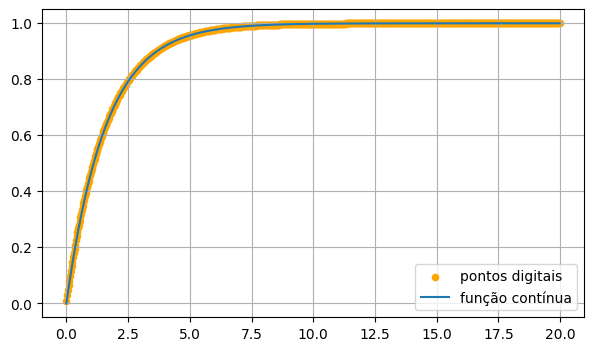

In [191]:
step = 1
digital = [compute(step) for t in time]
time, continuous = ctl.step_response(C, T=time)

plt.figure(figsize=(7, 4))
plt.scatter(time, digital, label='pontos digitais', color='orange', s=20)
plt.plot(time, continuous, label='função contínua')
plt.grid(), plt.legend()
plt.show()

# SIMULANDO SISTEMA

In [192]:
df = pd.read_csv('DataBase.csv')
df.head()

,time,analog
0,110.062839,4034.0
1,110.141765,4045.0
2,110.221532,4059.0
3,110.301835,4044.0
4,110.382143,4043.0


In [193]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData  = np.arange(initTime, finalTime, T)
    
    lastValue = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue
        
        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


df['time'] = df.time - df.time[0]
df = normalizeTable(df, 'time', T)
df

,time,analog
0,0.00,4034.0
1,0.03,4034.0
2,0.06,4034.0
3,0.09,4045.0
4,0.12,4045.0
...,...,...
4659,139.77,4095.0
4660,139.80,4095.0
4661,139.83,4095.0
4662,139.86,4095.0


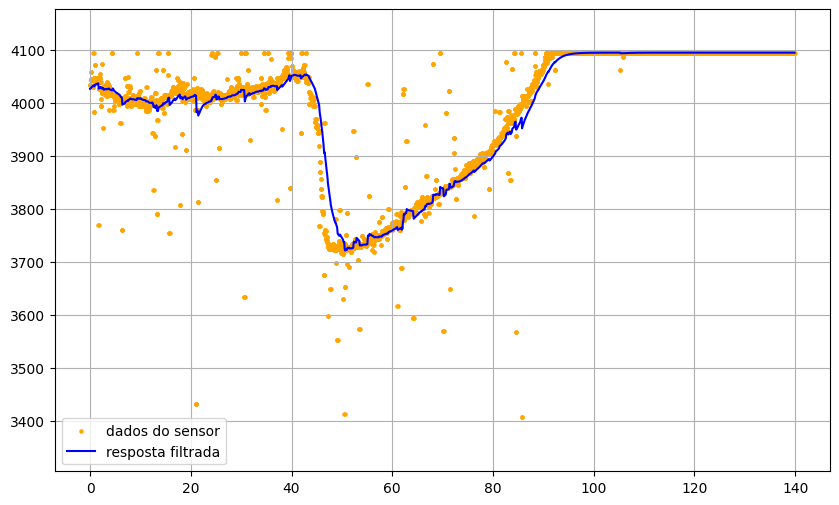

In [194]:
for i in range(1000): compute(df.loc[df.time < 5].analog.mean())

xData, yData = df.time.values, df.analog.values
response = [compute(val) for val in yData]

plt.figure(figsize=(10, 6))
plt.scatter(xData, yData, s=5, color='orange', label='dados do sensor')
plt.plot(xData, response, color='blue', label='resposta filtrada')
plt.ylim(yData.min()*0.97, yData.max()*1.02)
plt.legend(), plt.grid()
plt.show()